In [1]:
# Import libraries
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import seaborn as sns

import sys
sys.path.append('../python')  # Add the directory containing the module to the system path
import metrics  # Import the module
from models import HeuristicModel

In [4]:
seed = 42  # Set the random seed for reproducibility
np.random.seed(seed)

# Loading the data
X = np.load("../data/dataset_10/X_x.npy")
Y = np.load("../data/dataset_10/Y_y.npy")
Z = np.load("../data/dataset_10/Z_z.npy")
print(X.shape, Y.shape, Z.shape)

(40002, 10) (40002, 10) (40002,)


### Clustering

In [12]:
n_clusters = 3

In [13]:
D = X - Y

# Create the K-Means model
kmeans_model = KMeans(n_clusters=n_clusters, random_state=seed,n_init=1000,max_iter=1000,algorithm = 'elkan') 

# Fit the model to the data
kmeans_model.fit(D)

# Get the cluster labels for each data point
cluster_labels = kmeans_model.labels_

# Print cluster labels
print(cluster_labels)

[2 1 0 ... 2 2 2]


In [14]:
ari_score = adjusted_rand_score(Z, cluster_labels)
nmi_score = normalized_mutual_info_score(Z, cluster_labels, average_method='arithmetic')
cluster_intersection = metrics.ClusterIntersection()

print(f"Adjusted Rand Index: {ari_score:.4f}")
print(f"Normalized Mutual Information: {nmi_score:.4f}")
print("Cluster intersection samples:", cluster_intersection(cluster_labels, Z))

Adjusted Rand Index: 0.5028
Normalized Mutual Information: 0.4396
Cluster intersection samples: 0.7790082921543281


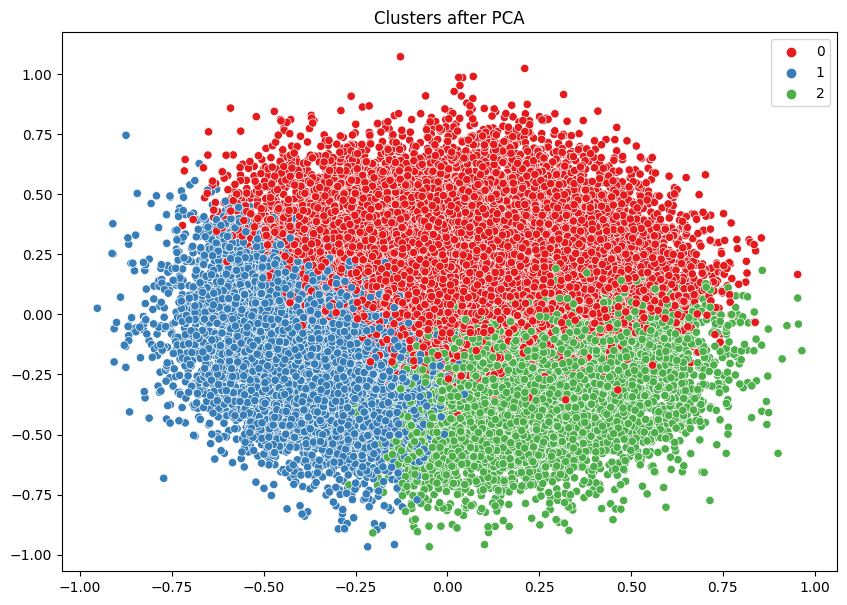

In [63]:
# Assuming 'X' is your dataset and 'kmeans' is your trained K-Means model
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Predicting the cluster labels
labels = kmeans_model.predict(X)

# Plotting
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='Set1')
plt.title('Clusters after PCA')
plt.show()


### Calculating Utility Function

In [15]:
unique_clusters = np.unique(cluster_labels)

models = {}  # Dictionary to store the logistic regression model for each cluster

for cluster in unique_clusters:
    # Filter rows for the current cluster
    X_cluster = X[cluster_labels == cluster]
    Y_cluster = Y[cluster_labels == cluster]
    
    # Concatenate X_cluster and Y_cluster vertically and create labels
    V = np.concatenate((X_cluster, Y_cluster), axis=0)
    labels = np.concatenate((np.ones(len(X_cluster)), np.zeros(len(Y_cluster))))  # 1 for X, 0 for Y

    # Create a random state
    rng = np.random.default_rng()
    
    # Create an array of indices and shuffle it
    indices = np.arange(V.shape[0])
    rng.shuffle(indices)

    # Use the shuffled indices to shuffle X and Y
    V = V[indices]
    labels = labels[indices]    
    
    # Initialize and train the logistic regression model
    model = LogisticRegression(max_iter=10000)
    model.fit(V, labels)
    
    # Predict on the test set and calculate accuracy
    labels_pred = model.predict(V)
    accuracy = accuracy_score(labels, labels_pred)
    print("Accuracy for cluster", cluster, ":", accuracy)
    # Store the model and accuracy for the cluster
    models[cluster] = model

Accuracy for cluster 0 : 0.8472950696838004
Accuracy for cluster 1 : 0.8392967781908303
Accuracy for cluster 2 : 0.8473151920838184


In [20]:
num_pairs = X.shape[0]
num_clusters = len(cluster_labels)
classification_matrix = np.zeros((num_pairs, num_clusters))
classified_clusters = np.zeros(num_pairs)

for i in range(len(unique_clusters)):
    model = models[i]
    
    # Assuming the model predicts probabilities, adjust if your model uses decision_function
    prob_X = model.predict_proba(X)[:, 1]  # Probability of being classified as 1 (from X)
    prob_Y = model.predict_proba(Y)[:, 1]
    
    # Compute the difference in probabilities
    classification_matrix[:, i] = prob_X - prob_Y

# Classify each pair into the cluster with the maximum difference
classified_clusters = np.argmax(classification_matrix, axis=1)
classified_clusters

array([2, 1, 0, ..., 2, 2, 2])

In [21]:
print("Cluster intersection samples:", cluster_intersection(classified_clusters, Z))

Cluster intersection samples: 0.767252365113551


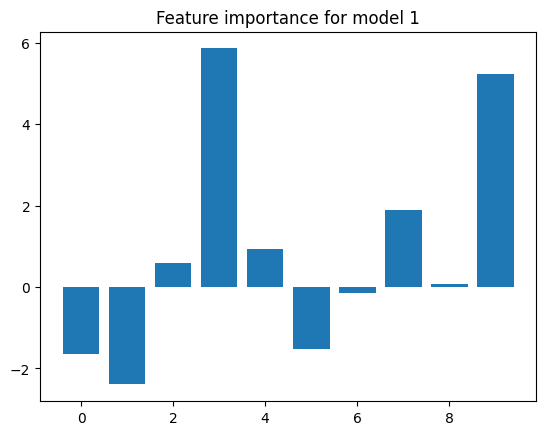

In [72]:
# Assume models is your list of Logistic Regression models
model = models[0]

plt.bar(range(len(model.coef_[0])), model.coef_[0])
plt.title("Feature importance for model 1")
plt.show()

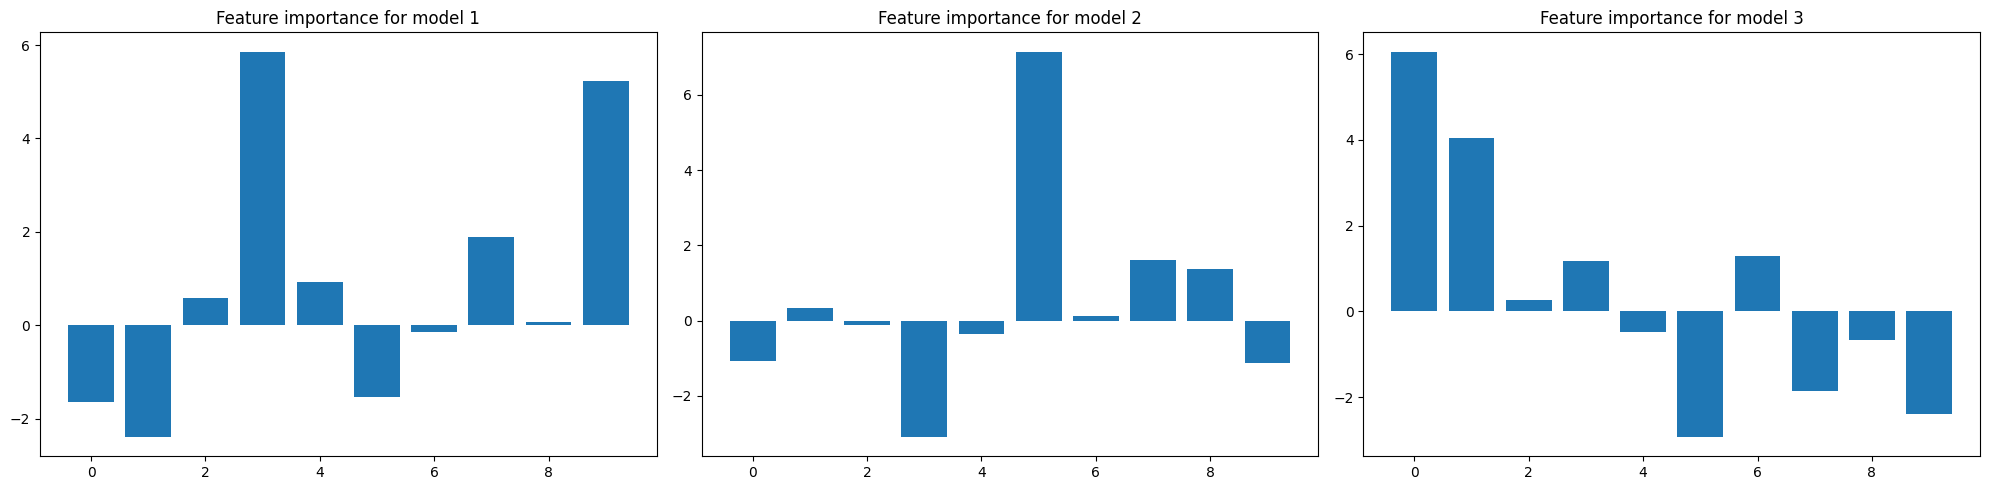

In [73]:
# Assume models is your list of Logistic Regression models
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i in range(3):
    axs[i].bar(range(len(models[i].coef_[0])), models[i].coef_[0])
    axs[i].set_title(f"Feature importance for model {i+1}")

plt.tight_layout()
plt.show()

### Testing modelclass


In [5]:
model_heuristic = HeuristicModel()

In [6]:
model_heuristic.fit(X, Y)

In [7]:
print((model_heuristic.predict_utility(X) - model_heuristic.predict_utility(Y))[:5]) # Preferred item has a higher utility

[[-0.76805391 -0.07690196  0.03994354]
 [-0.02772014  0.60611369 -0.68368662]
 [ 0.73986728  0.44660102 -0.92691457]
 [ 0.40641928 -0.57570675  0.05524974]
 [-0.76806758  0.08165372  0.17660213]]


In [8]:
print(model_heuristic.predict_preference(X, Y)[:5])

[[0 0 1]
 [0 1 0]
 [1 1 0]
 [1 0 1]
 [0 1 1]]


In [9]:
# Or we call directly the right metric:
pairs_explained = metrics.PairsExplained()
print("Percentage of explained preferences for all samples:", pairs_explained.from_model(model_heuristic, X, Y))
# Or other possibility:
print("Percentage of explained preferences for all samples:", pairs_explained(model_heuristic.predict_utility(X), model_heuristic.predict_utility(Y)))

Percentage of explained preferences for all samples: 0.9973001349932503
Percentage of explained preferences for all samples: 0.9973001349932503


In [10]:
# We consider that our model explains our data, if for at least one cluster, X[i] >> Y[i]
pairs_explained = np.sum(model_heuristic.predict_preference(X, Y)[:5] == 0, axis=1) # For each sample check if each clusters prefers X[i] (then is True)
pairs_explained = pairs_explained > 0 # If at least one cluster prefers X[i], then X[i] >> Y[i] is explained
print("Percentage of explained preferences for 5 first samples:", np.sum(pairs_explained) / 5) 

Percentage of explained preferences for 5 first samples: 1.0


In [11]:
print(model_heuristic.predict_cluster(X, Y)[:5])

[2 1 0 0 2]


In [12]:
# We have a metric to calculate how well the model has regrouped the preferences pairs compared to ground truth:
cluster_intersection = metrics.ClusterIntersection()

print("Cluster intersection for 5 first samples:", cluster_intersection(model_heuristic.predict_cluster(X, Y)[:5], Z[:5]))

# Then for all data:
print("Cluster intersection for all samples:", cluster_intersection(model_heuristic.predict_cluster(X, Y), Z))
print("Cluster intersection for all samples:", cluster_intersection.from_model(model_heuristic, X, Y, Z))

Cluster intersection for 5 first samples: 0.6
Cluster intersection for all samples: 0.767049375338038
Cluster intersection for all samples: 0.767049375338038
